In [5]:
from crear_dataset import *
from funcions_net import *
import numpy as np
import matplotlib.pyplot as plt
import pyreadstat
import pandas as pd
from preprocessing import *
from sklearn.model_selection import train_test_split
from funcions_net import *
from datasets_separats import *


In [6]:

df_orig, meta = pyreadstat.read_sav("CEJFEAjut2015Updated.sav")

df_variables = pd.read_csv("variables.csv", sep=';')

dict = create_dict(meta)

datasets = dataset_dif2(df_orig, dict,df_variables)

df_inicial = dataset_inicial(df_orig, dict)


df_psico = dataset_psicologia(df_orig, dict,df_variables)


df = drop_all_columns(df_psico, meta, df_variables, dict)


# Columnes que ja existeixen a df
columnes_comunes = df.columns.intersection(df_inicial.columns)

# Elimina les columnes duplicades de df_inicial
df_inicial_filtrat = df_inicial.drop(columns=columnes_comunes)

# Uneix columnes sense duplicats i alineant per fila
df = pd.concat([df.reset_index(drop=True), df_inicial_filtrat.reset_index(drop=True)], axis=1)



df["primer_mes"] = df_orig['temps_fins_reincidencia1a'].between(0, 30)




c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\datasets_separats.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  datasets[dataset_name][dict[i+1]] = df[dict[i+1]]
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\datasets_separats.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  datasets[dataset_name][dict[i+1]] = df[dict[i+1]]
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\datasets_separats.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

Creant dataset inicial
Creant dataset origen
(72, 15)
Creant dataset origen
(72, 37)
Delictes comesos
(72, 15)
Dataset final
(72, 15)
Dataset final
(72, 52)


c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\crear_dataset.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_actual['Gitanos'] = np.where(df_anterior['Etnia'] ==1, 1, 0)
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\crear_dataset.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_actual['Magrebins'] = np.where(df_anterior['Etnia'] ==2, 1, 0)
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\crear_dataset.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [7]:
df["primer_mes"].value_counts()


primer_mes
False    48
True     24
Name: count, dtype: int64

In [8]:
df.shape

(72, 189)

In [9]:
print("Mirem quants nans tenim a cada columna")
netejat,df = neteja_na_columns(df, llindar=0.6)

df = omple_nans(df)

print("Columnes netejades")
## fem label encoding de les columnes categòriques
df = label_encoding(df)


Mirem quants nans tenim a cada columna
Columnes netejades


In [10]:
num_columnes = df.shape[1]
print("Hem netejat les columnes i hem fet label encoding")
print("Tenim ", num_columnes, " columnes")

Hem netejat les columnes i hem fet label encoding
Tenim  175  columnes


In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='primer_mes'), df['primer_mes'], test_size=0.2,random_state=20, stratify=df['primer_mes'])


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_train = pd.DataFrame(X_train, columns=df.drop(columns='primer_mes').columns)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, GridSearchCV

def grid_search_random_forest_with_rfe(X_resampled, y_resampled, tecnica):
    print(f"\n🔍 Aplicant RFE per seleccionar 50 característiques abans de {tecnica}")

    # Inicialitzem un model base per a RFE (pot ser RandomForest perquè té feature_importances_)
    base_rf = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Aplicar RFE amb RandomForest com a model base
    rfe_selector = RFE(estimator=base_rf, n_features_to_select=100, step=0.1)
    X_selected = rfe_selector.fit_transform(X_resampled, y_resampled)

    print(f"✅ Seleccionades {X_selected.shape[1]} característiques després de RFE")

    # Ara fem Grid Search amb Random Forest usant només les característiques seleccionades
    rf = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 10, 15, 20],
    }

    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(estimator=rf,
                               param_grid=param_grid,
                               scoring='f1',
                               cv=stratified_cv,
                               n_jobs=-1,
                               verbose=1)

    grid_search.fit(X_selected, y_resampled)

    print(f"🏆 Millors paràmetres trobats amb {tecnica}: {grid_search.best_params_}")
    print(f"📊 Millor score (F1 CV) amb {tecnica}: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_, rfe_selector

# Exemple d'ús:
best_rf_model, rfe_selector = grid_search_random_forest_with_rfe(X_train, y_train, "Grid Search amb RFE")



🔍 Aplicant RFE per seleccionar 50 característiques abans de Grid Search amb RFE
✅ Seleccionades 100 característiques després de RFE
Fitting 5 folds for each of 15 candidates, totalling 75 fits
🏆 Millors paràmetres trobats amb Grid Search amb RFE: {'max_depth': 3, 'n_estimators': 50}
📊 Millor score (F1 CV) amb Grid Search amb RFE: 0.1143


In [15]:
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score


def avaluar_model(model, nom_model, X_test, y_test):
    print(f"\n📊 Avaluant {nom_model} sobre el conjunt de test")
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    print(f"AUC: {roc_auc_score(y_test, y_prob):.4f}")

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(nom_model)
    plt.show()

# Avaluació només del millor model (per exemple, el de SMOTE)
avaluar_model(best_rf_model, "Random Forest - SMOTE", X_test, y_test)


📊 Avaluant Random Forest - SMOTE sobre el conjunt de test


c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 174 features, but RandomForestClassifier is expecting 50 features as input.

In [48]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# 1. Oversampling simple
ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X_train, y_train)
print(f"Oversampling: {Counter(y_over)}")

# 2. Undersampling simple
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_train, y_train)
print(f"Undersampling: {Counter(y_under)}")

# 3. SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
print(f"SMOTE: {Counter(y_smote)}")

Oversampling: Counter({False: 38, True: 38})
Undersampling: Counter({False: 19, True: 19})
SMOTE: Counter({False: 38, True: 38})


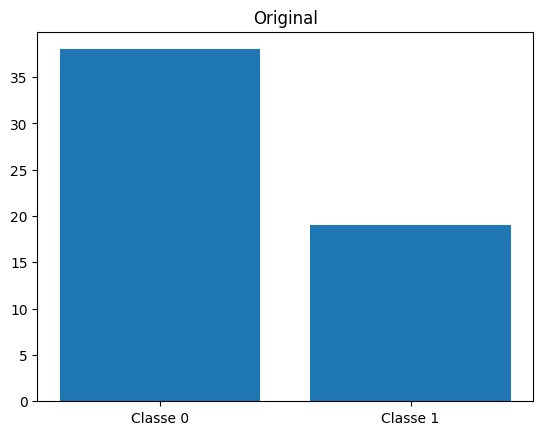

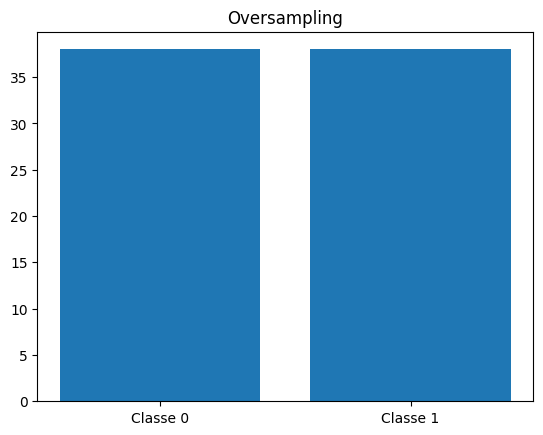

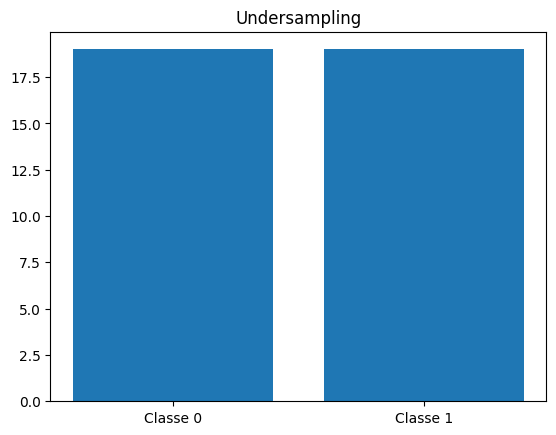

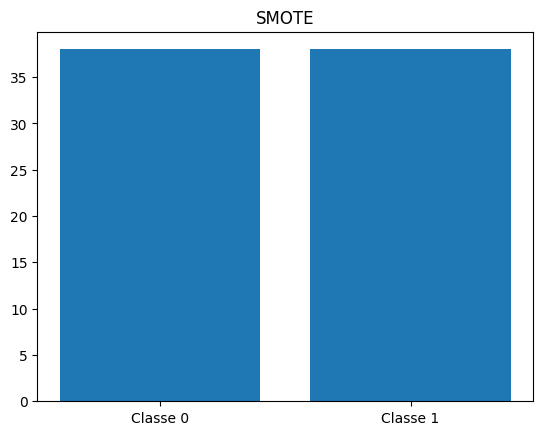

In [49]:
# Funció per visualitzar
def plot_distribution(y_data, title):
    counts = Counter(y_data)
    plt.bar(counts.keys(), counts.values())
    plt.xticks([0, 1], ['Classe 0', 'Classe 1'])
    plt.title(title)
    plt.show()

# Visualitzacions
plot_distribution(y_train, "Original")
plot_distribution(y_over, "Oversampling")
plot_distribution(y_under, "Undersampling")
plot_distribution(y_smote, "SMOTE")

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, GridSearchCV

def grid_search_random_forest(X_resampled, y_resampled, tecnica):
    print(f"\n🔍 Buscant hiperparàmetres amb {tecnica}")
    rf = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 10, 15, 20],
    }
    
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,scoring='f1', 
                               cv=stratified_cv, n_jobs=-1, verbose=1)
    grid_search.fit(X_resampled, y_resampled)

    print(f"Millors paràmetres trobats amb {tecnica}: {grid_search.best_params_}")
    print(f"Millor score (accuracy CV) amb {tecnica}: {grid_search.best_score_:.4f}")
    return grid_search.best_estimator_


In [51]:
# Entrenament amb GridSearch per cada conjunt augmentat
best_model_over = grid_search_random_forest(X_over, y_over, "Oversampling")
best_model_under = grid_search_random_forest(X_under, y_under, "Undersampling")
best_model_smote = grid_search_random_forest(X_smote, y_smote, "SMOTE")


🔍 Buscant hiperparàmetres amb Oversampling
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Millors paràmetres trobats amb Oversampling: {'max_depth': 10, 'n_estimators': 200}
Millor score (accuracy CV) amb Oversampling: 0.7718

🔍 Buscant hiperparàmetres amb Undersampling
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Millors paràmetres trobats amb Undersampling: {'max_depth': 3, 'n_estimators': 50}
Millor score (accuracy CV) amb Undersampling: 0.4797

🔍 Buscant hiperparàmetres amb SMOTE
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Millors paràmetres trobats amb SMOTE: {'max_depth': 5, 'n_estimators': 200}
Millor score (accuracy CV) amb SMOTE: 0.7513



📊 Avaluant Random Forest - Oversampling sobre el conjunt de test
              precision    recall  f1-score   support

       False       0.67      1.00      0.80        10
        True       0.00      0.00      0.00         5

    accuracy                           0.67        15
   macro avg       0.33      0.50      0.40        15
weighted avg       0.44      0.67      0.53        15

AUC: 0.3400


c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

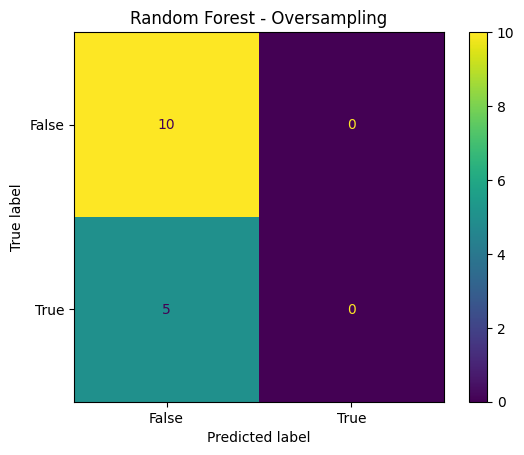


📊 Avaluant Random Forest - Undersampling sobre el conjunt de test
              precision    recall  f1-score   support

       False       0.00      0.00      0.00        10
        True       0.33      1.00      0.50         5

    accuracy                           0.33        15
   macro avg       0.17      0.50      0.25        15
weighted avg       0.11      0.33      0.17        15

AUC: 0.5200


c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

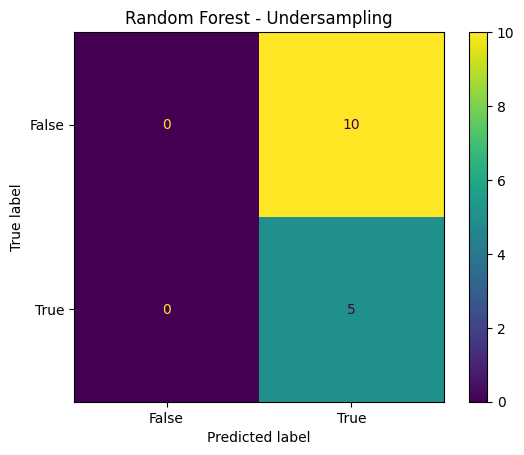


📊 Avaluant Random Forest - SMOTE sobre el conjunt de test
              precision    recall  f1-score   support

       False       0.69      0.90      0.78        10
        True       0.50      0.20      0.29         5

    accuracy                           0.67        15
   macro avg       0.60      0.55      0.53        15
weighted avg       0.63      0.67      0.62        15

AUC: 0.5400


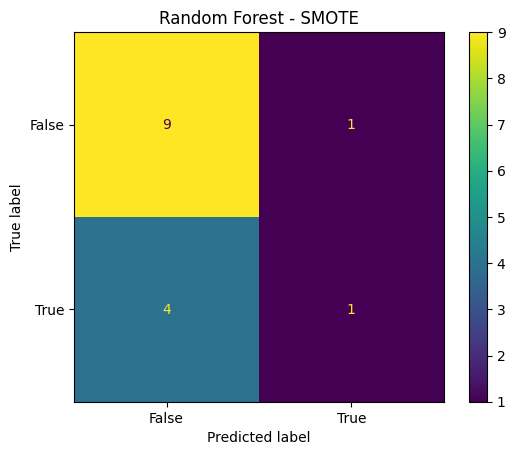

In [52]:
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

# Funció d'avaluació sobre el teu conjunt de test
def avaluar_model(model, nom_model, X_test, y_test):
    print(f"\n📊 Avaluant {nom_model} sobre el conjunt de test")
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    print(f"AUC: {roc_auc_score(y_test, y_prob):.4f}")

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(nom_model)
    plt.show()

# Avaluació dels tres models
avaluar_model(best_model_over, "Random Forest - Oversampling", X_test, y_test)
avaluar_model(best_model_under, "Random Forest - Undersampling", X_test, y_test)
avaluar_model(best_model_smote, "Random Forest - SMOTE", X_test, y_test)
